In [795]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools
import operator
import collections
import math

In [796]:
# Permanently changes the pandas settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.options.display.float_format = '{:20,.2f}'.format

In [797]:
def interest(data, rate):
    #hole output
    out = np.zeros_like(data, dtype = float)
    # initial deposit
    out[0] = data[0]
    for i in range(1, len(data)):
        # t + 1 = t * (1 + monthly) + deposit
        out[i] = out[i - 1] * (1 + rate) + data[i]
    return out

## Abkürzungen

* LS: Lohnsteuer
* GKV: Gesetzliche Krankenversicherung
* PKV: Private Krankenversicherung

## Parameter

In [798]:
# Termintechnische Daten
JAHR = 2024
EINTRITTSALTER = 23
ENDALTER = 105

# Personenbezigene Daten
LOHNSTEUER = 0.42
SOLIDARITAETSZUSCHLAG = 0
STEUERLAST = LOHNSTEUER + SOLIDARITAETSZUSCHLAG
STEUERLAST_RENTNER = 0.34
NETTOEINKOMMEN = 3300 # p.M.
EINKOMMENSENTWICKLUNG = 0.03 # p.a.

# Rente
RENTENEINTRITTSALTER = 70
RENTENANSPRUCH = 2500 # im Startjahr p.M.
RENTENENTWICKLUNG = 0.02 # p.a.
RENTENZUSCHUSS_PKV = 0.081
RENTENZUSCHUSS_PKV_MAX_ANTEIL = 0.5 # maximaler Anteil, der von der Rentenversicherung bezuschusst wird. 2024 max. 50%

# GKV (2024)
# https://www.bundesgesundheitsministerium.de/beitraege
GKV_BEITRAGSBEMESSUNGSGRENZE = 5175 # p.M.
GKV_BEITRAGSBEMESSUNGSGRENZE_STEIGERUNG = 0.0275 # p.a.
GKV_BEITRAG = 0.146 # Anteil vom Bruttogehalt
GKV_ZUSATZBEITRAG = 0.023 # Anteil vom Bruttogehalt
GKV_ANTEIL_ARBEITGEBER = 0.5
GKV_ANTEIL_RENTENVERSICHERUNG = 0.5
GKV_GESAMTBEITRAG = GKV_BEITRAG + GKV_ZUSATZBEITRAG
GKV_GESAMTBEITRAG_INKL_AG = GKV_GESAMTBEITRAG * (1 - GKV_ANTEIL_ARBEITGEBER)
GKV_GESAMTBEITRAG_INKL_RV = GKV_GESAMTBEITRAG * (1 - GKV_ANTEIL_RENTENVERSICHERUNG)
GKV_STEUERLICH_ANSETZBAR = 0.96 # Für Krankentagegeld wird vom Finanzamt pauschal 4% abgezogen

# Pflegeversicherung in GKV
# https://www.tk.de/firmenkunden/versicherung/beitraege-faq/pflegereform-2023/wie-hoch-ist-pv-beitrag-ab-01072023-2149454?tkcm=ab
GKV_PV_BEITRAG = 0.034 # Anteil vom Bruttogehalt
GKV_PV_KINDERLOSENZUSCHLAG = 0.006 # Anteil vom Bruttogehalt / kein AG Zuschuss
GKV_PV_ANTEIL_ARBEITGEBER = 0.5
GKV_PV_KINDER_ABSCHLAG_BIS = 24 # "unter 25 Jahre"
GKV_PV_KINDER_ABSCHLAG_STAFFELUNG = {
    2: 0.0025, 
    3: 0.005, 
    4: 0.0075, 
    5: 0.01,
    6: 0.01,
    7: 0.01,
    8: 0.01,
    9: 0.01,
    10: 0.01,
}

# Zusatzversicherungen in GKV
GKV_ZV_BEITRAG = 0
GKV_ZV_BEITRAGSSTEIGERUNG = 0.035 # p.a.

# PKV Tarif
PKV_VERSICHERUNG = 'Alte Oldenburger'
PKV_SELBSTBETEILIGUNG = {
    'max': 330,
    'anteil': 0.2,
}
PKV_TARIFKONDITIONEN = {
    'A 80/100': {
        'beitrag': 250.16, # exkl. Zusatz zu gesetzlicher Altersrückstellung (wird automatisch berechnet)
        'steuerlich_ansetzbar': 0.97,
        'wegfall_renteneintritt': False,
        'relevant_gesetzliche_altersrueckstellung': True,
    },
    'K 20': {
        'beitrag': 127.41,
        'steuerlich_ansetzbar': 0.6205,
        'wegfall_renteneintritt': False,
        'relevant_gesetzliche_altersrueckstellung': True,
    },
    'K/S': {
        'beitrag': 131.33 - 127.41,
        'steuerlich_ansetzbar': 0,
        'wegfall_renteneintritt': False,
        'relevant_gesetzliche_altersrueckstellung': True,
    },
    'Z 100/80': {
        'beitrag': 58.95,
        'steuerlich_ansetzbar': 0.6285,
        'wegfall_renteneintritt': False,
        'relevant_gesetzliche_altersrueckstellung': True,
    },
    'AK (Variante AK-E)': {
        'beitrag': 0.95,
        'steuerlich_ansetzbar': 0,
        'wegfall_renteneintritt': False,
        'relevant_gesetzliche_altersrueckstellung': False,
    },
    'KTV 6 140€': {
        'beitrag': 40.04,
        'steuerlich_ansetzbar': 0,
        'wegfall_renteneintritt': True,
        'relevant_gesetzliche_altersrueckstellung': False,
    },
}
PKV_BEITRAGSSTEIGERUNG = 0.035 # p.a.
PKV_ANTEIL_ARBEITGEBER = 0.5
PKV_BEITRAGSENTLASTUNGSPAKET = {
    'bezeichnung': 'PBE 2.0 350€',
    'beitrag': 0, #141.40,
    'steuerlich_ansetzbar': -1, # wenn auf -1 gesetz wird der Anteil automatisch berechnet (durchschnittliche Absetzbarkeit)
    'relevant_gesetzliche_altersrueckstellung': False,
}
PKV_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB = 65 # Beitragssenkung ab 65
PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB = 65 # Beitragssenkung ab 65
PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS = 60 # Einzahlung bis x Jahre
PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL = 0.1
PKV_GESETZLICHE_BEITRAGSENTLASTUNG_REDUKTION = 0.07 # Beitrag wird um 8% gesenkt ab 65
PKV_BEITRAGSENTLASTUNG_RENDITE = 0.02 # p.a.
PKV_PV = {
    'bezeichnung': 'PVN',
    'beitrag': 50.47,
    'steuerlich_ansetzbar': 1,
    'relevant_gesetzliche_altersrueckstellung': False,
}
PKV_PV_ANTEIL_ARBEITGEBER = 0.5

# Kinder
KINDER = [
    {
        'alter_bei_geburt': 30,
        'versicherungsdauer': 24, # in Jahren (bis zum 24ten Geburtstag)
    },
    {
        'alter_bei_geburt': 32,
        'versicherungsdauer': 24, # in Jahren (bis zum 24ten Geburtstag)
    },
]
PKV_KINDER_BEITRAG = 150 # in 2024 (Inflation wird im Rechner beachtet)
PKV_KINDER_BEITRAGSSTEIGERUNG = 0.035 # p.a.

# Kapitalmarkt und Wirtschaft
INFLATIONSRATE = 0.025 # p.a.
RENDITE_KAPITALMARKT = 0.05 # p.a.
KAPITALERTRAGSSTEUER = 0.25

# Vermögensaufbau
ON_TOP_INVESTIEREN_BETRAG = 100 # bis Rente werden 100€ über die PKV Preisvorteile hinaus investiert
ON_TOP_INVESTIEREN_BEITRAGSAUTOMATIK = 0.02 # p.a.
ON_TOP_INVESTIEREN_BIS = 50
REDUKTION_ETF_AB = RENTENEINTRITTSALTER # Der ETF wird ab Rentenalter zum verringern der Beiträge verwendet
REDUKTION_ETF = 0.6 # Die Rate der PKV wird um 60% reduziert

## Vorberechnungen

In [799]:
s = PKV_BEITRAGSENTLASTUNGSPAKET['beitrag'] + PKV_PV['beitrag']
for t in PKV_TARIFKONDITIONEN.values():
    s += t['beitrag']
s

531.9

In [800]:
min_x = math.ceil(EINTRITTSALTER / 10.0) * 10
major_ticks = np.arange(min_x, ENDALTER, 10)
minor_ticks = np.arange(min_x, ENDALTER, 5)

In [801]:
beitrag, _, _, _ = functools.reduce(operator.add, map(collections.Counter, PKV_TARIFKONDITIONEN.values())).values()
beitrag += PKV_PV['beitrag']
durchschnittliche_ansetzbarkeit = (PKV_PV['beitrag'] / beitrag) * PKV_PV['steuerlich_ansetzbar']
for konditionen in PKV_TARIFKONDITIONEN.values():
    durchschnittliche_ansetzbarkeit += (konditionen['beitrag'] / beitrag) * konditionen['steuerlich_ansetzbar']
if PKV_BEITRAGSENTLASTUNGSPAKET['steuerlich_ansetzbar'] == -1:
    PKV_BEITRAGSENTLASTUNGSPAKET['steuerlich_ansetzbar'] = durchschnittliche_ansetzbarkeit
durchschnittliche_ansetzbarkeit

0.7693799210377892

## Einkommensentwicklung

In [802]:
df = pd.DataFrame()

In [803]:
df['Jahr'] = np.arange(JAHR, JAHR - EINTRITTSALTER + ENDALTER + 1)
df['Alter'] = np.arange(EINTRITTSALTER, ENDALTER + 1)
df[f'Inflation seit {JAHR}'] = np.power(1 + INFLATIONSRATE, df['Jahr'] - JAHR)
df['Rentenbezug'] = df['Alter'] >= RENTENEINTRITTSALTER
df['Einkommen'] = NETTOEINKOMMEN * np.power(1 + EINKOMMENSENTWICKLUNG, df['Alter'] - EINTRITTSALTER) * (1 - df['Rentenbezug'])
df['Rente'] = RENTENANSPRUCH * np.power(1 + RENTENENTWICKLUNG, df['Alter'] - EINTRITTSALTER) * df['Rentenbezug']

df

,Jahr,Alter,Inflation seit 2024,Rentenbezug,Einkommen,Rente
0,2024,23,1.00,False,"3,300.00",0.00
1,2025,24,1.02,False,"3,399.00",0.00
2,2026,25,1.05,False,"3,500.97",0.00
3,2027,26,1.08,False,"3,606.00",0.00
4,2028,27,1.10,False,"3,714.18",0.00
5,2029,28,1.13,False,"3,825.60",0.00
6,2030,29,1.16,False,"3,940.37",0.00
7,2031,30,1.19,False,"4,058.58",0.00
8,2032,31,1.22,False,"4,180.34",0.00
9,2033,32,1.25,False,"4,305.75",0.00


## GKV Beiträge

In [804]:
kinder_sortiert = sorted(KINDER, key=lambda k: k['alter_bei_geburt'])
alter_wenn_erstes_kind = kinder_sortiert[0]['alter_bei_geburt'] if len(kinder_sortiert) > 0 else 1000
alter_wenn_letztes_kind = kinder_sortiert[-1]['alter_bei_geburt'] + kinder_sortiert[-1]['versicherungsdauer'] if len(kinder_sortiert) > 0 else 1000

anzahl_kinder_pv_relevant = np.zeros(ENDALTER - EINTRITTSALTER + 1)
for kind in KINDER:
    start = kind['alter_bei_geburt'] - EINTRITTSALTER
    ende = start + GKV_PV_KINDER_ABSCHLAG_BIS
    for i in range(start, ende + 1):
        anzahl_kinder_pv_relevant[i] += 1


df['GKV: Kinderlos'] = df['Alter'] < alter_wenn_erstes_kind
df[f'GKV: Kinder bis {GKV_PV_KINDER_ABSCHLAG_BIS} Jahre'] = anzahl_kinder_pv_relevant.astype(int)
df[f'GKV: Kinder bis {GKV_PV_KINDER_ABSCHLAG_BIS} Jahre PV Abschlag'] = df[f'GKV: Kinder bis {GKV_PV_KINDER_ABSCHLAG_BIS} Jahre'].map(GKV_PV_KINDER_ABSCHLAG_STAFFELUNG).fillna(0)

df['GKV: Beitragsbemessungsgrenze'] = GKV_BEITRAGSBEMESSUNGSGRENZE * np.power(1 + GKV_BEITRAGSBEMESSUNGSGRENZE_STEIGERUNG, df['Alter'] - EINTRITTSALTER)

df['GKV: Beitrag inkl. AG Anteil'] = df['GKV: Beitragsbemessungsgrenze'] * GKV_GESAMTBEITRAG_INKL_AG * (1 - df['Rentenbezug'])
df['GKV: PV Beitrag inkl. AG Anteil'] = df['GKV: Beitragsbemessungsgrenze'] * (GKV_PV_BEITRAG * (1 - GKV_PV_ANTEIL_ARBEITGEBER) + GKV_PV_KINDERLOSENZUSCHLAG * df['GKV: Kinderlos'] - df[f'GKV: Kinder bis {GKV_PV_KINDER_ABSCHLAG_BIS} Jahre PV Abschlag']) * (1 - df['Rentenbezug'])
df['GKV: Gesamt Beitrag inkl. AG Anteil'] = df['GKV: Beitrag inkl. AG Anteil'] + df['GKV: PV Beitrag inkl. AG Anteil']

df['GKV: Beitrag Rente inkl. RV Anteil'] = np.minimum(df['Rente'], df['GKV: Beitragsbemessungsgrenze']) * GKV_GESAMTBEITRAG_INKL_RV * df['Rentenbezug']
df['GKV: PV Beitrag Rente'] = np.minimum(df['Rente'], df['GKV: Beitragsbemessungsgrenze']) * (GKV_PV_BEITRAG + GKV_PV_KINDERLOSENZUSCHLAG * df['GKV: Kinderlos'] - df[f'GKV: Kinder bis {GKV_PV_KINDER_ABSCHLAG_BIS} Jahre PV Abschlag']) * df['Rentenbezug']
df['GKV: Gesamt Beitrag Rente inkl. RV Anteil'] = df['GKV: Beitrag Rente inkl. RV Anteil'] + df['GKV: PV Beitrag Rente']

df['GKV: Beitrag inkl. Zuschüsse exkl. LS'] = np.where(df['Rentenbezug'], df['GKV: Gesamt Beitrag Rente inkl. RV Anteil'], df['GKV: Gesamt Beitrag inkl. AG Anteil'])
df['GKV: Steuererstattung'] = df['GKV: Beitrag inkl. Zuschüsse exkl. LS'] * np.where(df['Rentenbezug'], STEUERLAST_RENTNER, STEUERLAST) * GKV_STEUERLICH_ANSETZBAR
df['GKV: Beitrag inkl. Zuschüsse inkl. LS'] = df['GKV: Beitrag inkl. Zuschüsse exkl. LS'] - df['GKV: Steuererstattung']

df.loc[:, ~df.columns.str.startswith('PKV: ')]

,Jahr,Alter,Inflation seit 2024,Rentenbezug,Einkommen,Rente,GKV: Kinderlos,GKV: Kinder bis 24 Jahre,GKV: Kinder bis 24 Jahre PV Abschlag,GKV: Beitragsbemessungsgrenze,GKV: Beitrag inkl. AG Anteil,GKV: PV Beitrag inkl. AG Anteil,GKV: Gesamt Beitrag inkl. AG Anteil,GKV: Beitrag Rente inkl. RV Anteil,GKV: PV Beitrag Rente,GKV: Gesamt Beitrag Rente inkl. RV Anteil,GKV: Beitrag inkl. Zuschüsse exkl. LS,GKV: Steuererstattung,GKV: Beitrag inkl. Zuschüsse inkl. LS
0,2024,23,1.00,False,"3,300.00",0.00,True,0,0.00,"5,175.00",437.29,119.02,556.31,0.00,0.00,0.00,556.31,224.31,332.01
1,2025,24,1.02,False,"3,399.00",0.00,True,0,0.00,"5,317.31",449.31,122.30,571.61,0.00,0.00,0.00,571.61,230.47,341.14
2,2026,25,1.05,False,"3,500.97",0.00,True,0,0.00,"5,463.54",461.67,125.66,587.33,0.00,0.00,0.00,587.33,236.81,350.52
3,2027,26,1.08,False,"3,606.00",0.00,True,0,0.00,"5,613.79",474.36,129.12,603.48,0.00,0.00,0.00,603.48,243.32,360.16
4,2028,27,1.10,False,"3,714.18",0.00,True,0,0.00,"5,768.17",487.41,132.67,620.08,0.00,0.00,0.00,620.08,250.02,370.06
5,2029,28,1.13,False,"3,825.60",0.00,True,0,0.00,"5,926.79",500.81,136.32,637.13,0.00,0.00,0.00,637.13,256.89,380.24
6,2030,29,1.16,False,"3,940.37",0.00,True,0,0.00,"6,089.78",514.59,140.06,654.65,0.00,0.00,0.00,654.65,263.96,390.70
7,2031,30,1.19,False,"4,058.58",0.00,False,1,0.00,"6,257.25",528.74,106.37,635.11,0.00,0.00,0.00,635.11,256.08,379.03
8,2032,31,1.22,False,"4,180.34",0.00,False,1,0.00,"6,429.32",543.28,109.30,652.58,0.00,0.00,0.00,652.58,263.12,389.46
9,2033,32,1.25,False,"4,305.75",0.00,False,2,0.00,"6,606.13",558.22,95.79,654.01,0.00,0.00,0.00,654.01,263.70,390.31


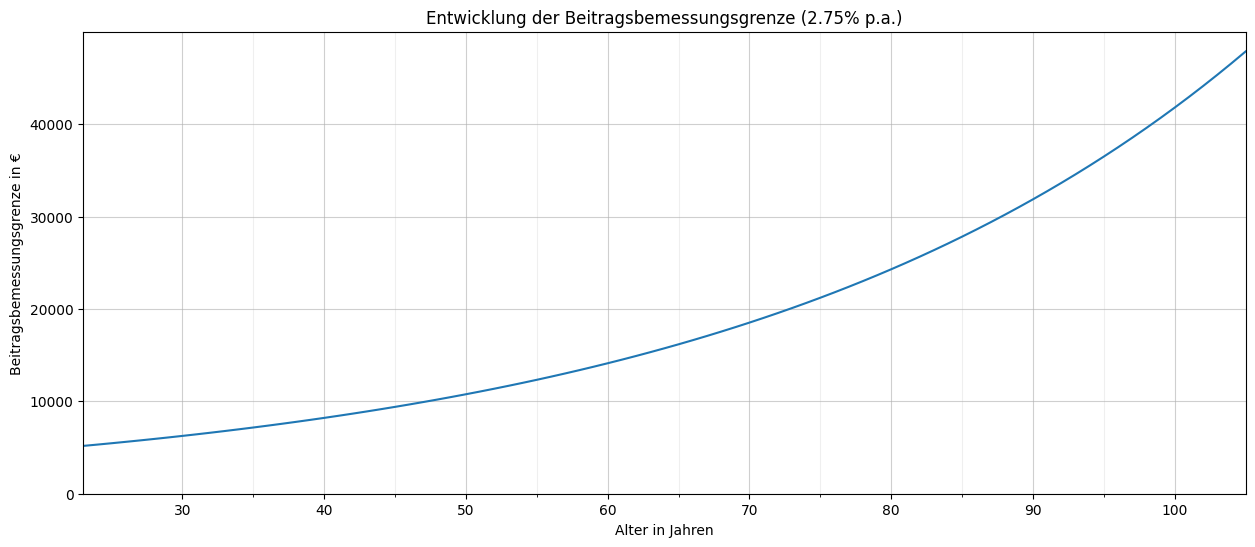

In [805]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 6))

plt.plot(df['Alter'], df['GKV: Beitragsbemessungsgrenze'])

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title(f'Entwicklung der Beitragsbemessungsgrenze ({GKV_BEITRAGSBEMESSUNGSGRENZE_STEIGERUNG * 100}% p.a.)')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitragsbemessungsgrenze in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.show()

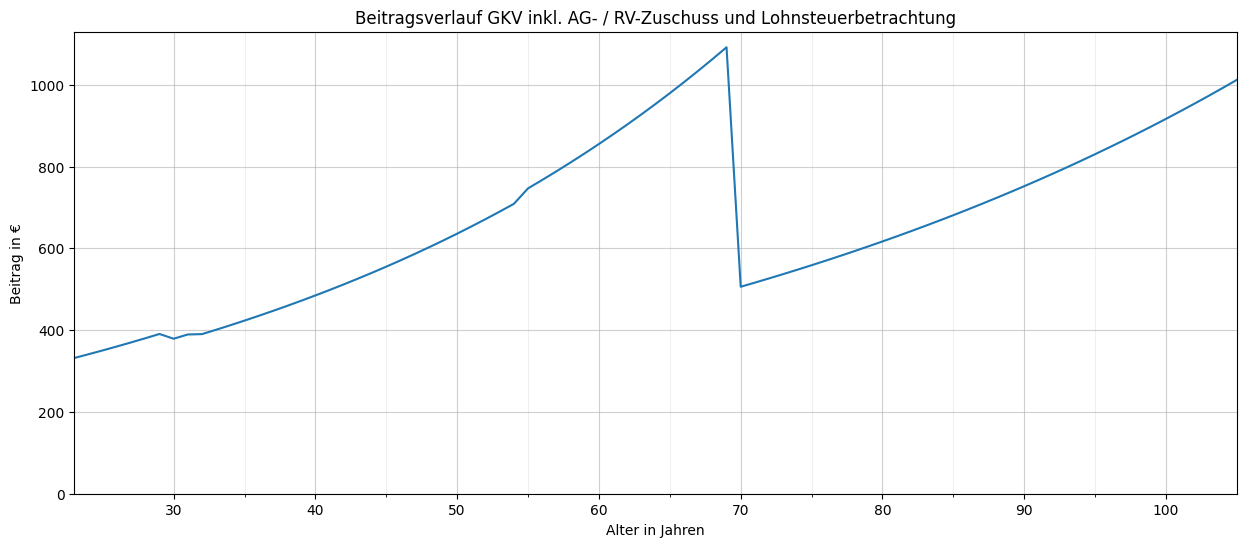

In [806]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 6))

plt.plot(df['Alter'], df['GKV: Beitrag inkl. Zuschüsse inkl. LS'])

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title(f'Beitragsverlauf GKV inkl. AG- / RV-Zuschuss und Lohnsteuerbetrachtung')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.show()

## PKV Beiträge

In [807]:
# Kinder
alter_wenn_erstes_kind
anzahl_mitversicherter_kinder = np.zeros(ENDALTER - EINTRITTSALTER + 1)
for kind in KINDER:
    start = kind['alter_bei_geburt'] - EINTRITTSALTER
    ende = start + kind['versicherungsdauer']
    for i in range(start, ende):
        anzahl_mitversicherter_kinder[i] += 1
df['PKV: Anzahl Kinder'] = anzahl_mitversicherter_kinder.astype(int)

# Beiträge vor Lohnsteuerbetrachtung
for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
    df[f'PKV: Beitrag {tarif} exkl. LS'] = konditionen['beitrag'] * np.power(1 +  PKV_BEITRAGSSTEIGERUNG, df['Alter'] - EINTRITTSALTER) * np.where((df['Alter'] >= RENTENEINTRITTSALTER) & konditionen['wegfall_renteneintritt'], 0, 1)
df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS'] = PKV_BEITRAGSENTLASTUNGSPAKET['beitrag'] * np.power(1 +  PKV_BEITRAGSSTEIGERUNG, df['Alter'] - EINTRITTSALTER)
df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} exkl. LS'] = PKV_PV['beitrag'] * np.power(1 + PKV_BEITRAGSSTEIGERUNG, df['Alter'] - EINTRITTSALTER)
df['PKV: Beitrag Kinder exkl. LS'] = PKV_KINDER_BEITRAG * np.power(1 + PKV_BEITRAGSSTEIGERUNG, df['Alter'] - EINTRITTSALTER) * df['PKV: Anzahl Kinder']

# gesetzliche Altersrückstellungen
df['PKV: gesetzlicher Zuschlag zur Beitragsentlastung'] = df['Alter'] < PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS
for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
    if konditionen['relevant_gesetzliche_altersrueckstellung']:
        df[f'PKV: Einzahlung Altersrückstellungen (gesetzlich) {tarif}'] = np.where(df['Alter'] <= PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, df[f'PKV: Beitrag {tarif} exkl. LS'] * PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL, 0)
        df[f'PKV: Beitrag {tarif} exkl. LS'] += df[f'PKV: Einzahlung Altersrückstellungen (gesetzlich) {tarif}']
df['PKV: Beitrag Gesamt exkl. LS'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS') & ~df.columns.str.contains('Gesamt')].sum(axis=1)
df['PKV: Beitrag Gesamt exkl. PV exkl. LS'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS') & ~df.columns.str.contains('Gesamt') & ~df.columns.str.contains(PKV_PV["bezeichnung"])].sum(axis=1)
df['PKV: Einzahlung Altersrückstellungen (gesetzlich) Gesamt'] = df.loc[:, df.columns.str.startswith('PKV: Einzahlung Altersrückstellungen (gesetzlich) ') & ~df.columns.str.contains('Gesamt')].sum(axis=1)

# Wertentwicklung und Auszahlung gesetzlicher Altersrückstellungen
for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
    if konditionen['relevant_gesetzliche_altersrueckstellung']:
        df[f'PKV: Auszahlung Altersrückstellungen (gesetzlich) {tarif}'] = np.where(df['Alter'] >= PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, df[f'PKV: Beitrag {tarif} exkl. LS'] * PKV_GESETZLICHE_BEITRAGSENTLASTUNG_REDUKTION, 0)
        df[f'PKV: Gebildete Altersrückstellungen (gesetzlich) {tarif}'] = np.maximum(0, interest((df[f'PKV: Einzahlung Altersrückstellungen (gesetzlich) {tarif}'] - df[f'PKV: Auszahlung Altersrückstellungen (gesetzlich) {tarif}']) * 12, PKV_BEITRAGSENTLASTUNG_RENDITE))
        df[f'PKV: Auszahlung Altersrückstellungen (gesetzlich) {tarif}'] = np.where(df[f'PKV: Gebildete Altersrückstellungen (gesetzlich) {tarif}'] == 0, 0, np.minimum(df[f'PKV: Gebildete Altersrückstellungen (gesetzlich) {tarif}'] / 12, df[f'PKV: Auszahlung Altersrückstellungen (gesetzlich) {tarif}']))
df['PKV: Auszahlung Altersrückstellungen (gesetzlich) Gesamt'] = df.loc[:, df.columns.str.startswith('PKV: Auszahlung Altersrückstellungen (gesetzlich) ') & ~df.columns.str.contains('Gesamt')].sum(axis=1)
df['PKV: Gebildete Altersrückstellungen (gesetzlich) Gesamt'] = df.loc[:, df.columns.str.startswith('PKV: Gebildete Altersrückstellungen (gesetzlich) ') & ~df.columns.str.contains('Gesamt')].sum(axis=1)

# Beiträge inkl. Altersrückstellung
for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
    if konditionen['relevant_gesetzliche_altersrueckstellung']:
        df[f'PKV: Beitrag {tarif} exkl. LS inkl. AR'] = df[f'PKV: Beitrag {tarif} exkl. LS'] - df[f'PKV: Auszahlung Altersrückstellungen (gesetzlich) {tarif}']
    else:
        df[f'PKV: Beitrag {tarif} exkl. LS inkl. AR'] = df[f'PKV: Beitrag {tarif} exkl. LS']
df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS inkl. AR'] = df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS']
df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} exkl. LS inkl. AR'] = df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} exkl. LS']
df['PKV: Beitrag Kinder exkl. LS inkl. AR'] = df['PKV: Beitrag Kinder exkl. LS']
df['PKV: Beitrag Gesamt exkl. LS inkl. AR'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS inkl. AR') & ~df.columns.str.contains('Gesamt')].sum(axis=1)
df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS inkl. AR') & ~df.columns.str.contains('Gesamt') & ~df.columns.str.contains(PKV_PV["bezeichnung"])].sum(axis=1)

# Zuschüsse AG
df['PKV: AG Zuschuss Gesamt exkl. PV'] = np.minimum(df['GKV: Beitragsbemessungsgrenze'] * GKV_GESAMTBEITRAG, df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * (1 - PKV_ANTEIL_ARBEITGEBER) * (1 - df['Rentenbezug'])
for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
    df[f'PKV: AG Zuschuss {tarif}'] = (df[f'PKV: Beitrag {tarif} exkl. LS inkl. AR'] / df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * df['PKV: AG Zuschuss Gesamt exkl. PV'] * (1 - df['Rentenbezug'])
df['PKV: AG Zuschuss Kinder'] = (df['PKV: Beitrag Kinder exkl. LS inkl. AR'] / df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * df['PKV: AG Zuschuss Gesamt exkl. PV'] * (1 - df['Rentenbezug'])
df[f'PKV: AG Zuschuss {PKV_PV["bezeichnung"]}'] = np.minimum(df['GKV: Beitragsbemessungsgrenze'] * GKV_PV_BEITRAG, df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} exkl. LS inkl. AR']) * (1 - PKV_PV_ANTEIL_ARBEITGEBER) * (1 - df['Rentenbezug'])
df[f'PKV: AG Zuschuss {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]}'] = (df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS inkl. AR'] / df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * df['PKV: AG Zuschuss Gesamt exkl. PV'] * (1 - df['Rentenbezug'])
df['PKV: AG Zuschuss Gesamt exkl. PV'] = df.loc[:, df.columns.str.startswith('PKV: AG Zuschuss ') & ~df.columns.str.contains('Gesamt') & ~df.columns.str.contains(PKV_PV["bezeichnung"])].sum(axis=1)

# Zuschüsse RV
df['PKV: RV Zuschuss Gesamt exkl. PV'] = np.minimum(df['Rente'] * RENTENZUSCHUSS_PKV, df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR'] * RENTENZUSCHUSS_PKV_MAX_ANTEIL)
for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
    df[f'PKV: RV Zuschuss {tarif}'] = (df[f'PKV: Beitrag {tarif} exkl. LS inkl. AR'] / df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * df['PKV: RV Zuschuss Gesamt exkl. PV'] * df['Rentenbezug']
df['PKV: RV Zuschuss Kinder'] = (df['PKV: Beitrag Kinder exkl. LS inkl. AR'] / df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * df['PKV: RV Zuschuss Gesamt exkl. PV'] * df['Rentenbezug']
df[f'PKV: RV Zuschuss {PKV_PV["bezeichnung"]}'] = 0
df[f'PKV: RV Zuschuss {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]}'] = (df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS inkl. AR'] / df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * df['PKV: RV Zuschuss Gesamt exkl. PV'] * df['Rentenbezug']
df['PKV: RV Zuschuss Gesamt exkl. PV'] = df.loc[:, df.columns.str.startswith('PKV: RV Zuschuss ') & ~df.columns.str.contains('Gesamt') & ~df.columns.str.contains(PKV_PV["bezeichnung"])].sum(axis=1)

# Beiträge inkl. Zuschüsse
for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
    df[f'PKV: Beitrag {tarif} inkl. Zuschüsse exkl. LS inkl. AR'] = df[f'PKV: Beitrag {tarif} exkl. LS inkl. AR'] - df[f'PKV: AG Zuschuss {tarif}'] - df[f'PKV: RV Zuschuss {tarif}']
df['PKV: Beitrag Kinder inkl. Zuschüsse exkl. LS inkl. AR'] = df['PKV: Beitrag Kinder exkl. LS inkl. AR'] - df['PKV: AG Zuschuss Kinder'] - df['PKV: RV Zuschuss Kinder']
df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} inkl. Zuschüsse exkl. LS inkl. AR'] = df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} exkl. LS inkl. AR'] - df[f'PKV: AG Zuschuss {PKV_PV["bezeichnung"]}'] - df[f'PKV: RV Zuschuss {PKV_PV["bezeichnung"]}']
df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} inkl. Zuschüsse exkl. LS inkl. AR'] = df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS inkl. AR'] - df[f'PKV: AG Zuschuss {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]}'] - df[f'PKV: RV Zuschuss {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]}']
df['PKV: Beitrag Gesamt inkl. Zuschüsse exkl. PV exkl. LS inkl. AR'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' inkl. Zuschüsse exkl. LS inkl. AR') & ~df.columns.str.contains('Gesamt') & ~df.columns.str.contains(PKV_PV["bezeichnung"])].sum(axis=1)
df['PKV: Beitrag Gesamt inkl. Zuschüsse exkl. LS inkl. AR'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' inkl. Zuschüsse exkl. LS inkl. AR') & ~df.columns.str.contains('Gesamt')].sum(axis=1)

# Steuererstattung
for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
    df[f'PKV: Steuererstattung {tarif}'] = df[f'PKV: Beitrag {tarif} inkl. Zuschüsse exkl. LS inkl. AR'] * konditionen['steuerlich_ansetzbar'] * np.where(df['Rentenbezug'], STEUERLAST_RENTNER, STEUERLAST)
df['PKV: Steuererstattung Kinder'] = df['PKV: Beitrag Kinder inkl. Zuschüsse exkl. LS inkl. AR'] * np.where(df['Rentenbezug'], STEUERLAST_RENTNER, STEUERLAST)
df[f'PKV: Steuererstattung {PKV_PV["bezeichnung"]}'] = df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} inkl. Zuschüsse exkl. LS inkl. AR'] * PKV_PV['steuerlich_ansetzbar'] * np.where(df['Rentenbezug'], STEUERLAST_RENTNER, STEUERLAST)
df[f'PKV: Steuererstattung {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]}'] = df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} inkl. Zuschüsse exkl. LS inkl. AR'] * PKV_BEITRAGSENTLASTUNGSPAKET['steuerlich_ansetzbar'] * np.where(df['Rentenbezug'], STEUERLAST_RENTNER, STEUERLAST)
df['PKV: Steuererstattung Gesamt'] = df.loc[:, df.columns.str.startswith('PKV: Steuererstattung ') & ~df.columns.str.contains('Gesamt')].sum(axis=1)

# Beiträge nach Steuern
for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
    df[f'PKV: Beitrag {tarif} inkl. Zuschüsse inkl. LS inkl. AR'] = df[f'PKV: Beitrag {tarif} inkl. Zuschüsse exkl. LS inkl. AR'] - df[f'PKV: Steuererstattung {tarif}']
df['PKV: Beitrag Kinder inkl. Zuschüsse inkl. LS inkl. AR'] = df['PKV: Beitrag Kinder inkl. Zuschüsse exkl. LS inkl. AR'] - df['PKV: Steuererstattung Kinder']
df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} inkl. Zuschüsse inkl. LS inkl. AR'] = df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} inkl. Zuschüsse exkl. LS inkl. AR'] - df[f'PKV: Steuererstattung {PKV_PV["bezeichnung"]}']
df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} inkl. Zuschüsse inkl. LS inkl. AR'] = df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} inkl. Zuschüsse exkl. LS inkl. AR'] - df[f'PKV: Steuererstattung {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]}']
df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' inkl. Zuschüsse inkl. LS inkl. AR') & ~df.columns.str.contains('Gesamt')].sum(axis=1)

df.loc[:, ~df.columns.str.startswith('GKV: ')]

/tmp/ipykernel_1175/1189791935.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'PKV: Beitrag {tarif} inkl. Zuschüsse inkl. LS inkl. AR'] = df[f'PKV: Beitrag {tarif} inkl. Zuschüsse exkl. LS inkl. AR'] - df[f'PKV: Steuererstattung {tarif}']
/tmp/ipykernel_1175/1189791935.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'PKV: Beitrag {tarif} inkl. Zuschüsse inkl. LS inkl. AR'] = df[f'PKV: Beitrag {tarif} inkl. Zuschüsse exkl. LS inkl. AR'] - df[f'PKV: Steuererstattung {tarif}']
/tmp/ipykernel_1175/1189791935.py:86

,Jahr,Alter,Inflation seit 2024,Rentenbezug,Einkommen,Rente,PKV: Anzahl Kinder,PKV: Beitrag A 80/100 exkl. LS,PKV: Beitrag K 20 exkl. LS,PKV: Beitrag K/S exkl. LS,PKV: Beitrag Z 100/80 exkl. LS,PKV: Beitrag AK (Variante AK-E) exkl. LS,PKV: Beitrag KTV 6 140€ exkl. LS,PKV: Beitrag PBE 2.0 350€ exkl. LS,PKV: Beitrag PVN exkl. LS,PKV: Beitrag Kinder exkl. LS,PKV: gesetzlicher Zuschlag zur Beitragsentlastung,PKV: Einzahlung Altersrückstellungen (gesetzlich) A 80/100,PKV: Einzahlung Altersrückstellungen (gesetzlich) K 20,PKV: Einzahlung Altersrückstellungen (gesetzlich) K/S,PKV: Einzahlung Altersrückstellungen (gesetzlich) Z 100/80,PKV: Beitrag Gesamt exkl. LS,PKV: Beitrag Gesamt exkl. PV exkl. LS,PKV: Einzahlung Altersrückstellungen (gesetzlich) Gesamt,PKV: Auszahlung Altersrückstellungen (gesetzlich) A 80/100,PKV: Gebildete Altersrückstellungen (gesetzlich) A 80/100,PKV: Auszahlung Altersrückstellungen (gesetzlich) K 20,PKV: Gebildete Altersrückstellungen (gesetzlich) K 20,PKV: Auszahlung Altersrückstellungen (gesetzlich) K/S,PKV: Gebildete Altersrückstellungen (gesetzlich) K/S,PKV: Auszahlung Altersrückstellungen (gesetzlich) Z 100/80,PKV: Gebildete Altersrückstellungen (gesetzlich) Z 100/80,PKV: Auszahlung Altersrückstellungen (gesetzlich) Gesamt,PKV: Gebildete Altersrückstellungen (gesetzlich) Gesamt,PKV: Beitrag A 80/100 exkl. LS inkl. AR,PKV: Beitrag K 20 exkl. LS inkl. AR,PKV: Beitrag K/S exkl. LS inkl. AR,PKV: Beitrag Z 100/80 exkl. LS inkl. AR,PKV: Beitrag AK (Variante AK-E) exkl. LS inkl. AR,PKV: Beitrag KTV 6 140€ exkl. LS inkl. AR,PKV: Beitrag PBE 2.0 350€ exkl. LS inkl. AR,PKV: Beitrag PVN exkl. LS inkl. AR,PKV: Beitrag Kinder exkl. LS inkl. AR,PKV: Beitrag Gesamt exkl. LS inkl. AR,PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR,PKV: AG Zuschuss Gesamt exkl. PV,PKV: AG Zuschuss A 80/100,PKV: AG Zuschuss K 20,PKV: AG Zuschuss K/S,PKV: AG Zuschuss Z 100/80,PKV: AG Zuschuss AK (Variante AK-E),PKV: AG Zuschuss KTV 6 140€,PKV: AG Zuschuss Kinder,PKV: AG Zuschuss PVN,PKV: AG Zuschuss PBE 2.0 350€,PKV: RV Zuschuss Gesamt exkl. PV,PKV: RV Zuschuss A 80/100,PKV: RV Zuschuss K 20,PKV: RV Zuschuss K/S,PKV: RV Zuschuss Z 100/80,PKV: RV Zuschuss AK (Variante AK-E),PKV: RV Zuschuss KTV 6 140€,PKV: RV Zuschuss Kinder,PKV: RV Zuschuss PVN,PKV: RV Zuschuss PBE 2.0 350€,PKV: Beitrag A 80/100 inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag K 20 inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag K/S inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag Z 100/80 inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag AK (Variante AK-E) inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag KTV 6 140€ inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag Kinder inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag PVN inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag PBE 2.0 350€ inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag Gesamt inkl. Zuschüsse exkl. PV exkl. LS inkl. AR,PKV: Beitrag Gesamt inkl. Zuschüsse exkl. LS inkl. AR,PKV: Steuererstattung A 80/100,PKV: Steuererstattung K 20,PKV: Steuererstattung K/S,PKV: Steuererstattung Z 100/80,PKV: Steuererstattung AK (Variante AK-E),PKV: Steuererstattung KTV 6 140€,PKV: Steuererstattung Kinder,PKV: Steuererstattung PVN,PKV: Steuererstattung PBE 2.0 350€,PKV: Steuererstattung Gesamt,PKV: Beitrag A 80/100 inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag K 20 inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag K/S inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag Z 100/80 inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag AK (Variante AK-E) inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag KTV 6 140€ inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag Kinder inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag PVN inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag PBE 2.0 350€ inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR
0,2024,23,1.00,False,"3,300.00",0.00,0,275.18,140.15,4.31,64.84,0.95,40.04,0.00,50.47,0.00,True,25.02,12.74,0.39,5.90,575.94,525.47,44.04,0.00,300.19,0.00,152.89,0.00,4.70,0.00,70.74,0.00,528.53,275.18,140.15,4.3

In [808]:
df.loc[:, df.columns.str.contains('A 80/100')]

,PKV: Beitrag A 80/100 exkl. LS,PKV: Einzahlung Altersrückstellungen (gesetzlich) A 80/100,PKV: Auszahlung Altersrückstellungen (gesetzlich) A 80/100,PKV: Gebildete Altersrückstellungen (gesetzlich) A 80/100,PKV: Beitrag A 80/100 exkl. LS inkl. AR,PKV: AG Zuschuss A 80/100,PKV: RV Zuschuss A 80/100,PKV: Beitrag A 80/100 inkl. Zuschüsse exkl. LS inkl. AR,PKV: Steuererstattung A 80/100,PKV: Beitrag A 80/100 inkl. Zuschüsse inkl. LS inkl. AR
0,275.18,25.02,0.00,300.19,275.18,137.59,0.00,137.59,56.05,81.53
1,284.81,25.89,0.00,616.89,284.81,142.40,0.00,142.40,58.02,84.39
2,294.78,26.80,0.00,950.81,294.78,147.39,0.00,147.39,60.05,87.34
3,305.09,27.74,0.00,"1,302.65",305.09,152.55,0.00,152.55,62.15,90.40
4,315.77,28.71,0.00,"1,673.18",315.77,157.89,0.00,157.89,64.32,93.56
5,326.82,29.71,0.00,"2,063.18",326.82,163.41,0.00,163.41,66.57,96.84
6,338.26,30.75,0.00,"2,473.45",338.26,169.13,0.00,169.13,68.90,100.23
7,350.10,31.83,0.00,"2,904.85",350.10,175.05,0.00,175.05,71.32,103.73
8,362.35,32.94,0.00,"3,358.24",362.35,181.18,0.00,181.18,73.81,107.37
9,375.04,34.09,0.00,"3,834.54",375.04,186.08,0.00,188.95,76.98,111.97


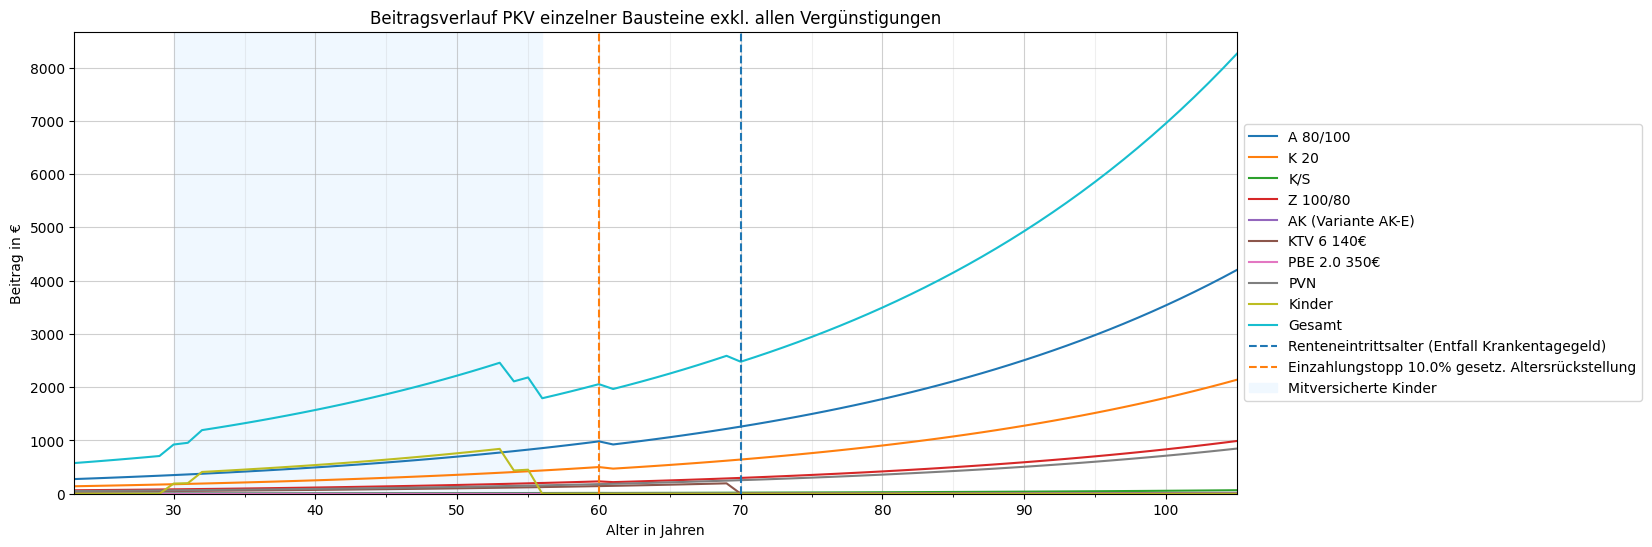

In [809]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 6))

to_plot = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS') & ~df.columns.str.contains('exkl. PV')].columns
for col in to_plot:
    plt.plot(df['Alter'], df[col], label=col.replace('PKV: Beitrag ', '').replace(' exkl. LS', ''))

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title('Beitragsverlauf PKV einzelner Bausteine exkl. allen Vergünstigungen')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

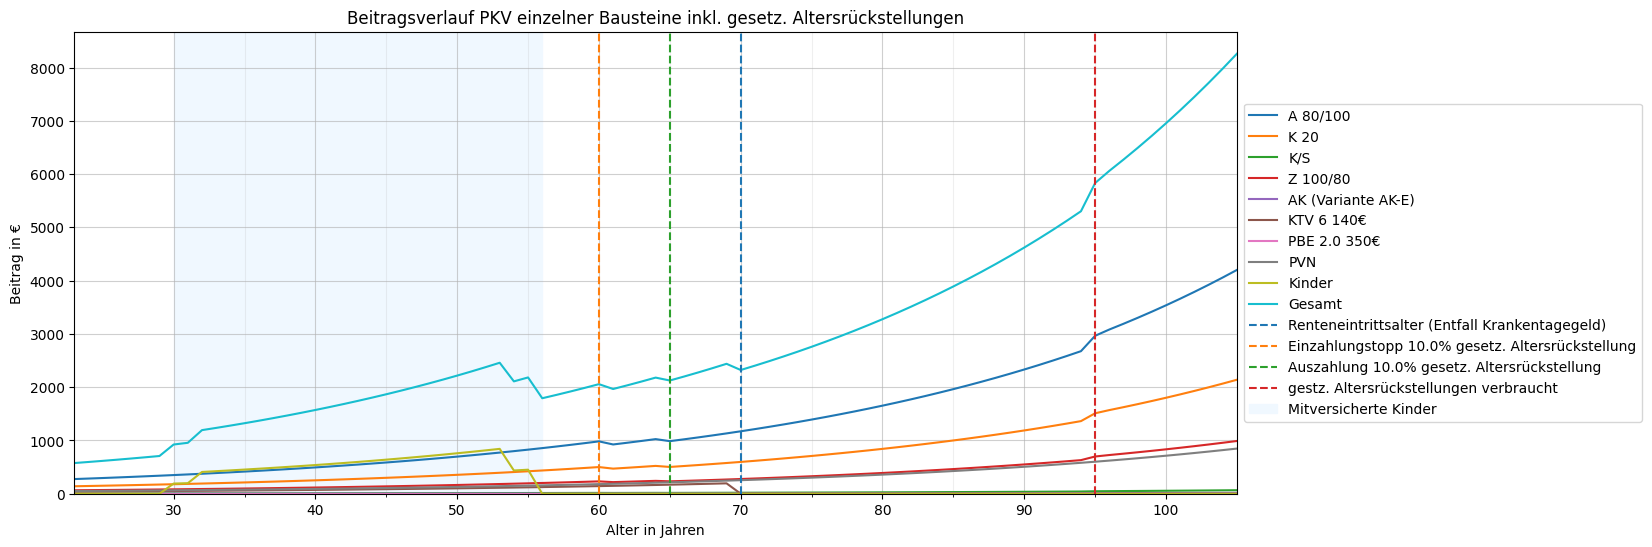

In [810]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 6))

gesetzliche_altersruckstellungen_verbraucht = ENDALTER
for i in df['PKV: Gebildete Altersrückstellungen (gesetzlich) Gesamt'][::-1]:
    if i > 0:
        break
    gesetzliche_altersruckstellungen_verbraucht -= 1

to_plot = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS inkl. AR') & ~df.columns.str.contains('inkl. Zuschüsse') & ~df.columns.str.contains('exkl. PV')].columns
for col in to_plot:
    plt.plot(df['Alter'], df[col], label=col.replace('PKV: Beitrag ', '').replace(' exkl. LS inkl. AR', ''))

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title('Beitragsverlauf PKV einzelner Bausteine inkl. gesetz. Altersrückstellungen')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

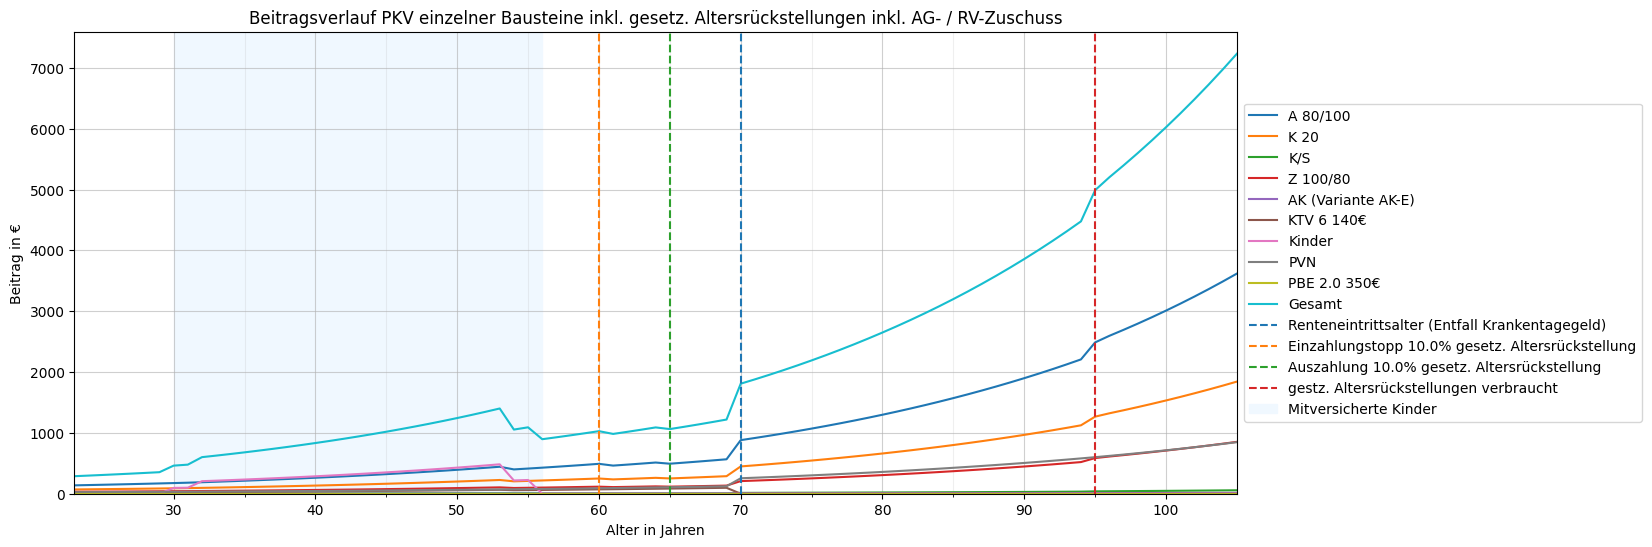

In [811]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 6))

to_plot = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' inkl. Zuschüsse exkl. LS inkl. AR') & ~df.columns.str.contains('exkl. PV')].columns
for col in to_plot:
    plt.plot(df['Alter'], df[col], label=col.replace('PKV: Beitrag ', '').replace(' inkl. Zuschüsse exkl. LS inkl. AR', ''))

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title('Beitragsverlauf PKV einzelner Bausteine inkl. gesetz. Altersrückstellungen inkl. AG- / RV-Zuschuss')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

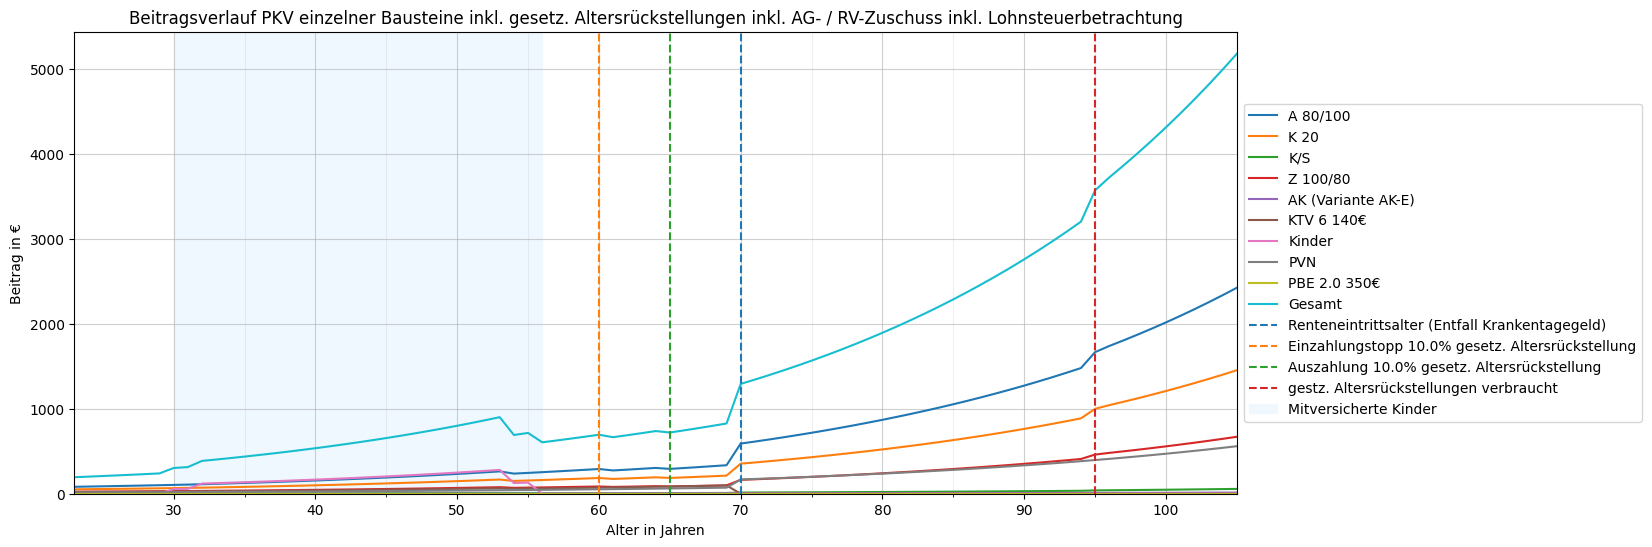

In [812]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 6))

to_plot = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' inkl. Zuschüsse inkl. LS inkl. AR') & ~df.columns.str.contains('exkl. PV')].columns
for col in to_plot:
    plt.plot(df['Alter'], df[col], label=col.replace('PKV: Beitrag ', '').replace(' inkl. Zuschüsse inkl. LS inkl. AR', ''))

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title('Beitragsverlauf PKV einzelner Bausteine inkl. gesetz. Altersrückstellungen inkl. AG- / RV-Zuschuss inkl. Lohnsteuerbetrachtung')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

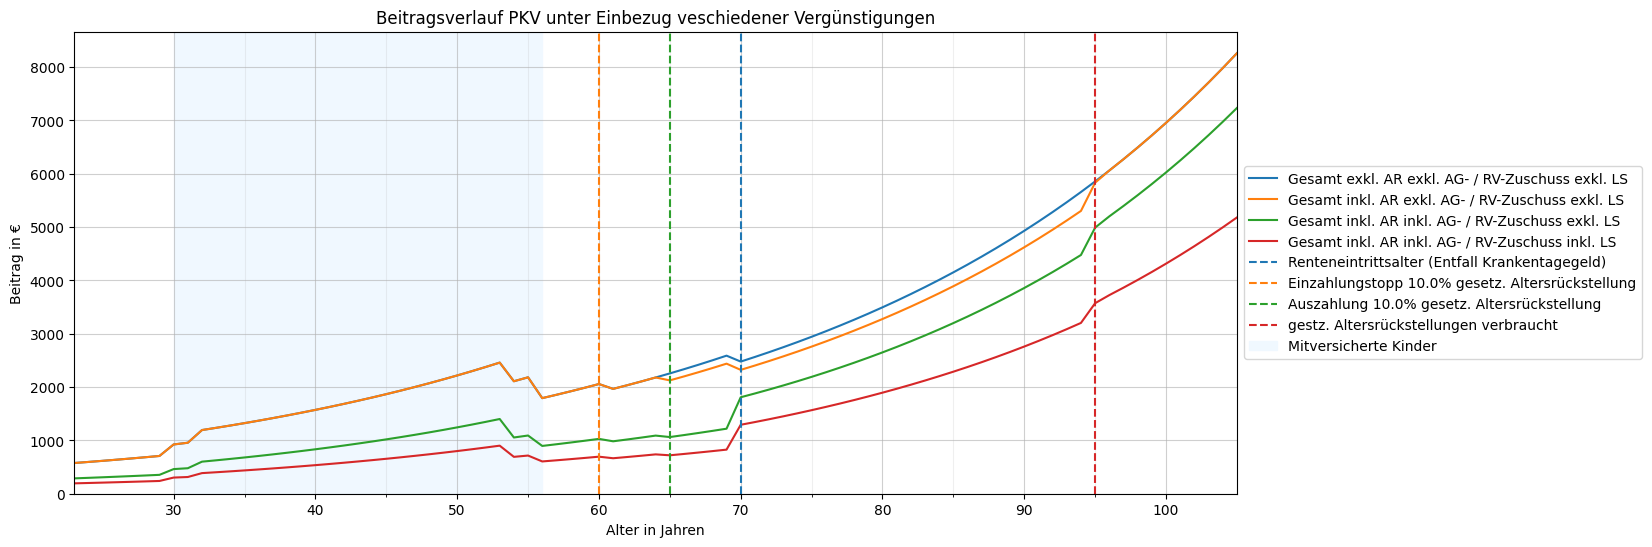

In [813]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 6))

plt.plot(df['Alter'], df['PKV: Beitrag Gesamt exkl. LS'], label='Gesamt exkl. AR exkl. AG- / RV-Zuschuss exkl. LS')
plt.plot(df['Alter'], df['PKV: Beitrag Gesamt exkl. LS inkl. AR'], label='Gesamt inkl. AR exkl. AG- / RV-Zuschuss exkl. LS')
plt.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse exkl. LS inkl. AR'], label='Gesamt inkl. AR inkl. AG- / RV-Zuschuss exkl. LS')
plt.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR'], label='Gesamt inkl. AR inkl. AG- / RV-Zuschuss inkl. LS')

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title('Beitragsverlauf PKV unter Einbezug veschiedener Vergünstigungen')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Vermögensaufbau

In [814]:
df['Ersparnis PKV vs. GKV'] = df['GKV: Beitrag inkl. Zuschüsse inkl. LS'] - df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR']
df['Zusätzlich investieren'] = np.where(df['Alter'] <= ON_TOP_INVESTIEREN_BIS, ON_TOP_INVESTIEREN_BETRAG * np.power(1 + ON_TOP_INVESTIEREN_BEITRAGSAUTOMATIK, df['Alter'] - EINTRITTSALTER), 0)
df['ETF Auszahlung (vor Steuer)'] = np.where(df['Alter'] >= REDUKTION_ETF_AB, df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR'] * REDUKTION_ETF / (1 - KAPITALERTRAGSSTEUER), 0)
df['Gebildete Ersparnisse in ETF'] = np.maximum(0, interest((np.maximum(df['Ersparnis PKV vs. GKV'], 0) + df['Zusätzlich investieren'] - df['ETF Auszahlung (vor Steuer)']) * 12, RENDITE_KAPITALMARKT))
df['ETF Auszahlung (vor Steuer)'] = np.where(df['Gebildete Ersparnisse in ETF'] == 0, 0, np.minimum(df['Gebildete Ersparnisse in ETF'] / 12, df['ETF Auszahlung (vor Steuer)']))
df['ETF Auszahlung (nach Steuer)'] = df['ETF Auszahlung (vor Steuer)'] * (1 - KAPITALERTRAGSSTEUER)

df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. ETF'] = df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR'] + np.maximum(df['Ersparnis PKV vs. GKV'], 0) + df['Zusätzlich investieren'] - df['ETF Auszahlung (nach Steuer)']

df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. ETF inflationsbereinigt'] = df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. ETF'] / df[f'Inflation seit {JAHR}']
df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inflationsbereinigt'] = df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR'] / df[f'Inflation seit {JAHR}']
df['GKV: Beitrag inkl. Zuschüsse inkl. LS inflationsbereinigt'] = df['GKV: Beitrag inkl. Zuschüsse inkl. LS'] / df[f'Inflation seit {JAHR}']

df[[
    'Alter',
    'Jahr',
    'Einkommen',
    'Rente',
    f'Inflation seit {JAHR}',
    'PKV: Anzahl Kinder',
    'GKV: Beitrag inkl. Zuschüsse inkl. LS',
    'PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR',
    'Ersparnis PKV vs. GKV',
    'Zusätzlich investieren',
    'Gebildete Ersparnisse in ETF',
    'ETF Auszahlung (vor Steuer)',
    'ETF Auszahlung (nach Steuer)',
    'PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. ETF',
    'PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. ETF inflationsbereinigt',
    'PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inflationsbereinigt',
    'GKV: Beitrag inkl. Zuschüsse inkl. LS inflationsbereinigt',
]]

/tmp/ipykernel_1175/1529830340.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Ersparnis PKV vs. GKV'] = df['GKV: Beitrag inkl. Zuschüsse inkl. LS'] - df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR']
/tmp/ipykernel_1175/1529830340.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Zusätzlich investieren'] = np.where(df['Alter'] <= ON_TOP_INVESTIEREN_BIS, ON_TOP_INVESTIEREN_BETRAG * np.power(1 + ON_TOP_INVESTIEREN_BEITRAGSAUTOMATIK, df['Alter'] - EINTRITTSALTER), 0)
/tmp/ipykernel_1175/1529830340.py:3: Per

,Alter,Jahr,Einkommen,Rente,Inflation seit 2024,PKV: Anzahl Kinder,GKV: Beitrag inkl. Zuschüsse inkl. LS,PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR,Ersparnis PKV vs. GKV,Zusätzlich investieren,Gebildete Ersparnisse in ETF,ETF Auszahlung (vor Steuer),ETF Auszahlung (nach Steuer),PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. ETF,PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. ETF inflationsbereinigt,PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inflationsbereinigt,GKV: Beitrag inkl. Zuschüsse inkl. LS inflationsbereinigt
0,23,2024,"3,300.00",0.00,1.00,0,332.01,194.50,137.51,100.00,"2,850.10",0.00,0.00,432.01,432.01,194.50,332.01
1,24,2025,"3,399.00",0.00,1.02,0,341.14,201.31,139.83,102.00,"5,894.58",0.00,0.00,443.14,432.33,196.40,332.82
2,25,2026,"3,500.97",0.00,1.05,0,350.52,208.35,142.17,104.04,"9,143.78",0.00,0.00,454.56,432.66,198.31,333.63
3,26,2027,"3,606.00",0.00,1.08,0,360.16,215.64,144.51,106.12,"12,608.59",0.00,0.00,466.28,432.99,200.25,334.44
4,27,2028,"3,714.18",0.00,1.10,0,370.06,223.19,146.87,108.24,"16,300.38",0.00,0.00,478.31,433.32,202.20,335.26
5,28,2029,"3,825.60",0.00,1.13,0,380.24,231.00,149.24,110.41,"20,231.12",0.00,0.00,490.65,433.66,204.17,336.08
6,29,2030,"3,940.37",0.00,1.16,0,390.70,239.09,151.61,112.62,"24,413.35",0.00,0.00,503.31,434.00,206.17,336.90
7,30,2031,"4,058.58",0.00,1.19,1,379.03,302.80,76.23,114.87,"27,927.23",0.00,0.00,493.90,415.50,254.74,318.87
8,31,2032,"4,180.34",0.00,1.22,1,389.46,313.40,76.06,117.17,"31,642.28",0.00,0.00,506.62,415.81,257.22,319.65
9,32,2033,"4,305.75",0.00,1.25,2,390.31,386.43,3.88,119.51,"34,705.02",0.00,0.00,509.82,408.23,309.43,312.53


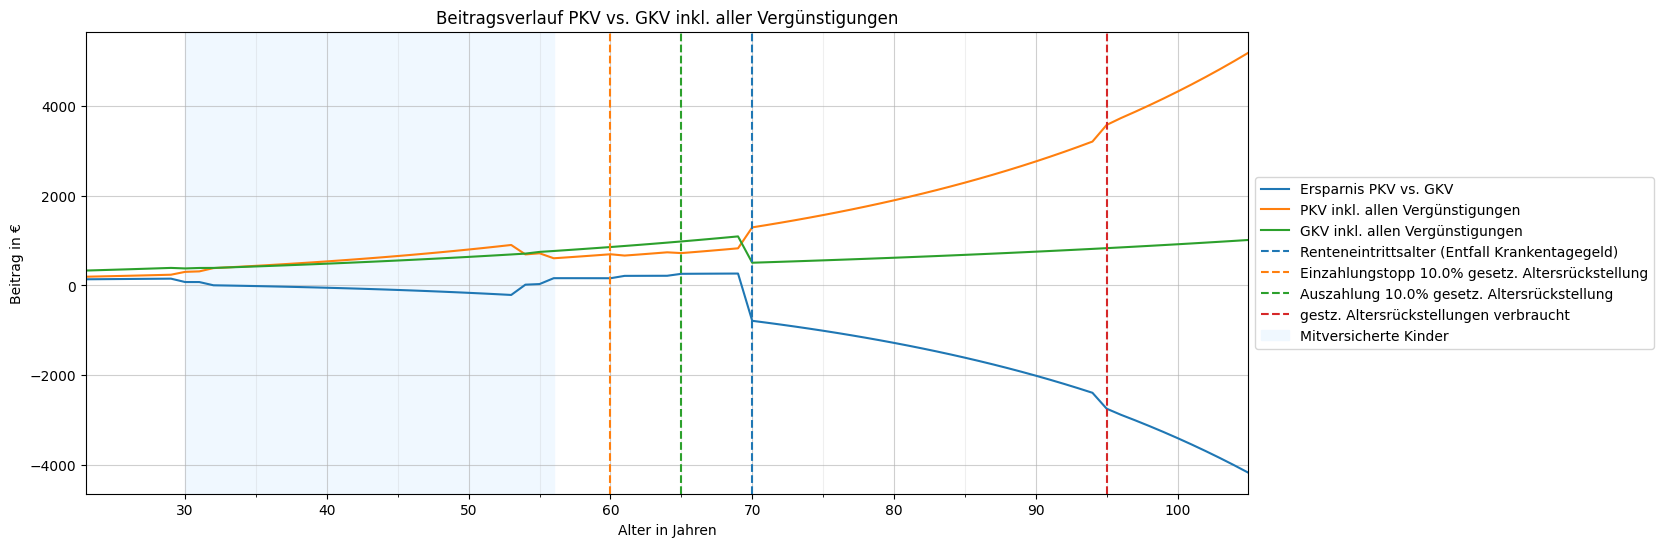

In [815]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 6))

plt.plot(df['Alter'], df['Ersparnis PKV vs. GKV'], label='Ersparnis PKV vs. GKV')
plt.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR'], label='PKV inkl. allen Vergünstigungen')
plt.plot(df['Alter'], df['GKV: Beitrag inkl. Zuschüsse inkl. LS'], label='GKV inkl. allen Vergünstigungen')

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title('Beitragsverlauf PKV vs. GKV inkl. aller Vergünstigungen')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

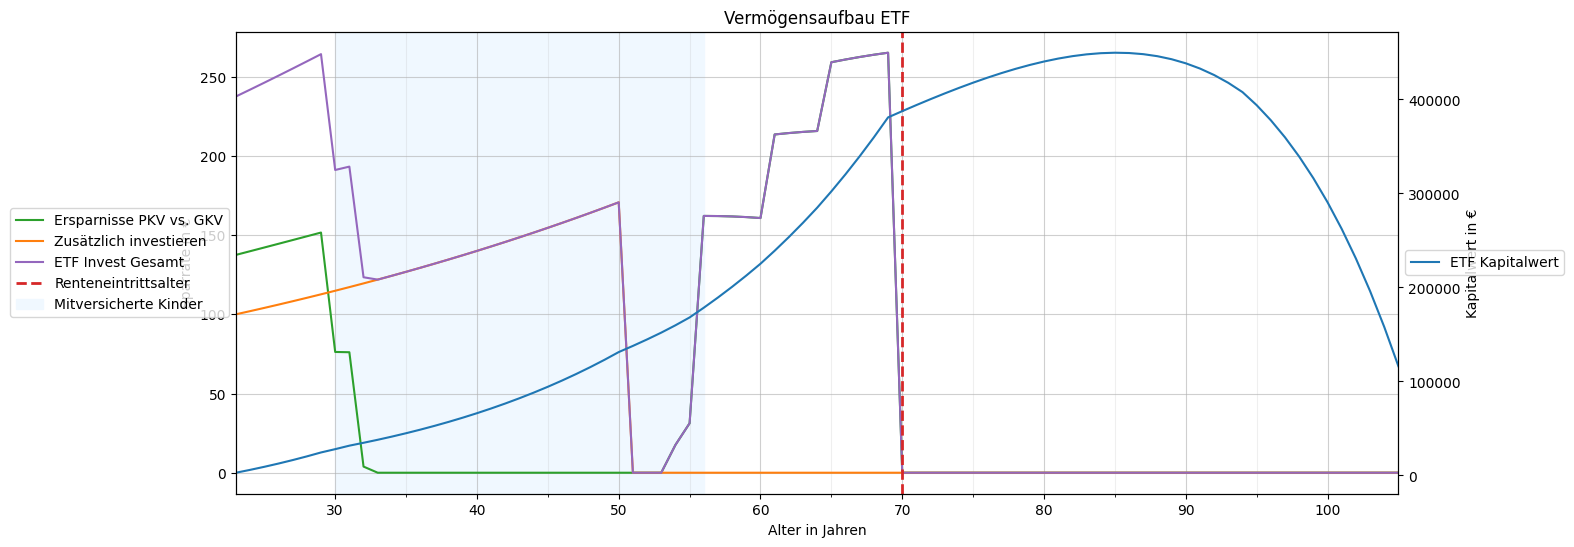

In [816]:
f, ax1 = plt.subplots(1)
f.set_size_inches((15, 6))
ax2 = ax1.twinx()

ax1.plot(df['Alter'], np.maximum(0, df['Ersparnis PKV vs. GKV']), label='Ersparnisse PKV vs. GKV', color='tab:green')
ax1.plot(df['Alter'], df['Zusätzlich investieren'], label='Zusätzlich investieren', color='tab:orange')
ax1.plot(df['Alter'], np.maximum(0, df['Ersparnis PKV vs. GKV']) + df['Zusätzlich investieren'], label='ETF Invest Gesamt', color='tab:purple')

ax1.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter", linestyle='dashed', color='tab:red', linewidth=2)

if alter_wenn_erstes_kind != 1000:
    ax1.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax2.plot(df['Alter'], df['Gebildete Ersparnisse in ETF'], label='ETF Kapitalwert', color='tab:blue')

ax1.set_xlim(left=EINTRITTSALTER)
ax1.set_xlim(right=ENDALTER)

ax1.set_title('Vermögensaufbau ETF')
ax1.set_xlabel('Alter in Jahren')
ax1.set_ylabel('Sparrate in €')
ax2.set_ylabel('Kapitalwert in €')

ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.6)

ax1.legend(loc='center right', bbox_to_anchor=(0, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

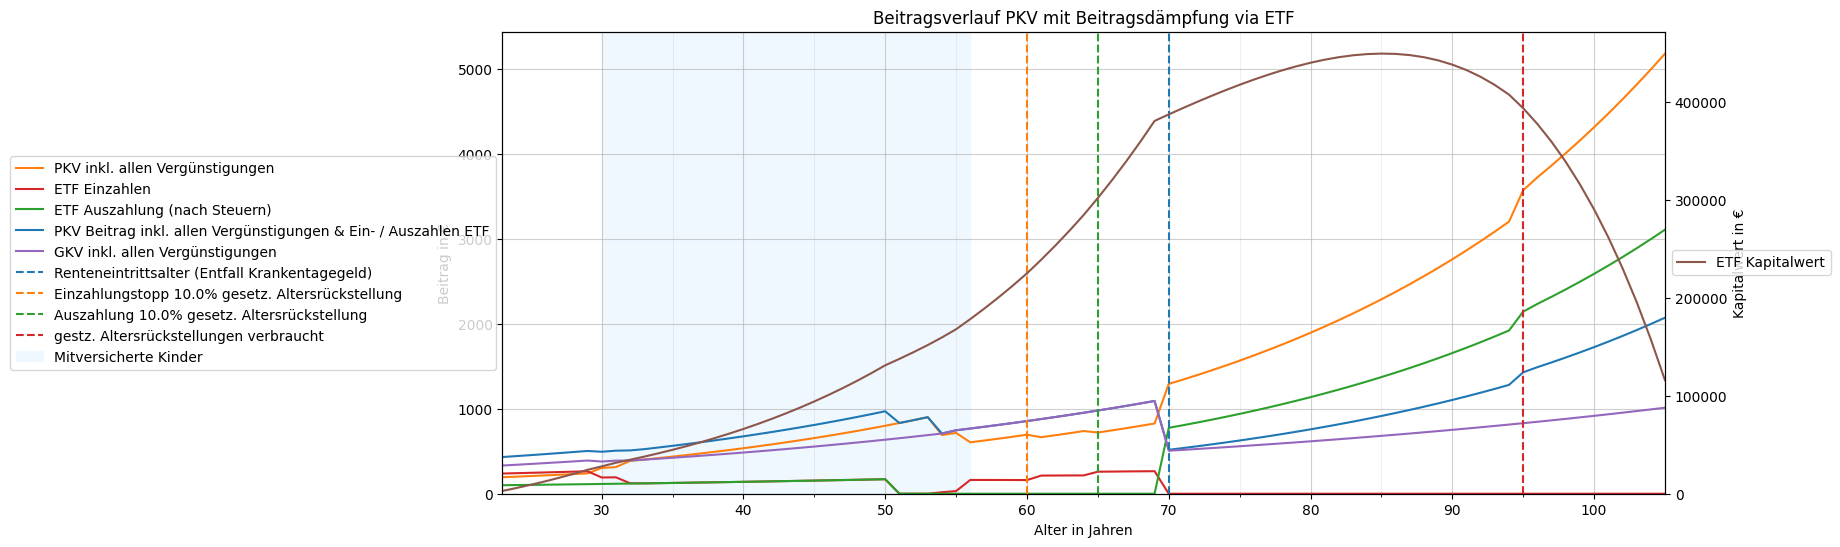

In [817]:
f, ax1 = plt.subplots(1)
f.set_size_inches((15, 6))
ax2 = ax1.twinx()

ax1.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR'], label='PKV inkl. allen Vergünstigungen', color='tab:orange')
ax1.plot(df['Alter'], np.maximum(0, df['Ersparnis PKV vs. GKV']) + df['Zusätzlich investieren'], label='ETF Einzahlen', color='tab:red')
ax1.plot(df['Alter'], np.maximum(0, df['ETF Auszahlung (nach Steuer)']) + df['Zusätzlich investieren'], label='ETF Auszahlung (nach Steuern)', color='tab:green')
ax1.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. ETF'], label='PKV Beitrag inkl. allen Vergünstigungen & Ein- / Auszahlen ETF', color='tab:blue')
ax1.plot(df['Alter'], df['GKV: Beitrag inkl. Zuschüsse inkl. LS'], label='GKV inkl. allen Vergünstigungen', color='tab:purple')

ax2.plot(df['Alter'], df['Gebildete Ersparnisse in ETF'], label='ETF Kapitalwert', color='tab:brown')

ax1.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax1.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax1.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax1.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax1.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax1.set_xlim(left=EINTRITTSALTER)
ax1.set_xlim(right=ENDALTER)

ax1.set_title('Beitragsverlauf PKV mit Beitragsdämpfung via ETF')
ax1.set_xlabel('Alter in Jahren')
ax1.set_ylabel('Beitrag in €')
ax2.set_ylabel('Kapitalwert in €')

ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.6)

ax1.legend(loc='center right', bbox_to_anchor=(0, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

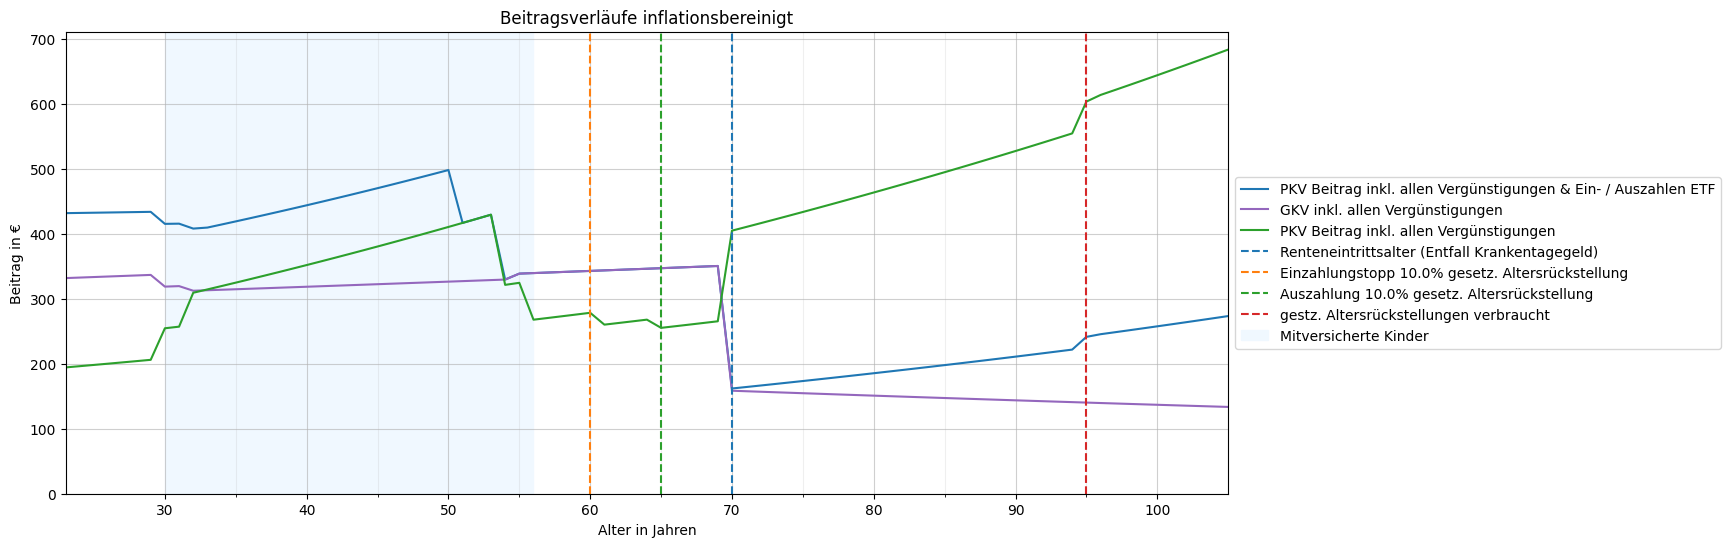

In [818]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 6))

plt.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. ETF inflationsbereinigt'], label='PKV Beitrag inkl. allen Vergünstigungen & Ein- / Auszahlen ETF', color='tab:blue')
plt.plot(df['Alter'], df['GKV: Beitrag inkl. Zuschüsse inkl. LS inflationsbereinigt'], label='GKV inkl. allen Vergünstigungen', color='tab:purple')
plt.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inflationsbereinigt'], label='PKV Beitrag inkl. allen Vergünstigungen', color='tab:green')

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title('Beitragsverläufe inflationsbereinigt')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Gesamtkosten inflationsbereinigt

In [819]:
(df[[
    'PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inflationsbereinigt',
    'PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. ETF inflationsbereinigt',
    'GKV: Beitrag inkl. Zuschüsse inkl. LS inflationsbereinigt',
]] * 12).sum()

PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inflationsbereinigt                       400,722.61
PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. ETF inflationsbereinigt             321,595.12
GKV: Beitrag inkl. Zuschüsse inkl. LS inflationsbereinigt                                       249,390.94
dtype: float64

In [820]:
restwert_etf_inflationsbereinigt = df.tail(1)['Gebildete Ersparnisse in ETF'].iloc[0] / df.tail(1)[f'Inflation seit {JAHR}'].iloc[0]
print(f'Restwert ETF inflationsbereinigt: {math.floor(restwert_etf_inflationsbereinigt)}€')

Restwert ETF inflationsbereinigt: 15328€
